In [1]:
from dataclasses import dataclass
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, vmap
import equinox as eqx
from typing import Callable, Union
import sys
sys.path.append("..")
from networks import FNO2d 
import networks.fno2d as fno2d
from traditional_solvers import Dx

import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap = plt.get_cmap('cmr.wildfire')
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
hparams = fno2d.Hparams(n_blocks=4, hidden_dim=64, modes_max=8, P=1.)
fno2d_instance = FNO2d(hparams)

In [3]:
x = jnp.linspace(0,1,2048, endpoint=False)
t = jnp.linspace(0,1,2048, endpoint=False)
a = jnp.sin(2*jnp.pi*x)**2 + 3*jnp.cos(2*jnp.pi*x)

In [ ]:
dx_ref = fno2d_instance.Dx(a, x, t)
dt_ref = fno2d_instance.Dt(a, x, t)

In [8]:
errors_fno2d_dx = []
errors_fno2d_dt = []
errors_finite_diff_dx = []
errors_finite_diff_dt = []
grid_size = [32, 64, 128, 256, 512, 1024]

for i, N in enumerate(grid_size):
    x = jnp.linspace(0,1,N, endpoint=False)
    t = jnp.linspace(0,1,N, endpoint=False)
    a = jnp.sin(2*jnp.pi*x)**2 + 3*jnp.cos(2*jnp.pi*x)
    fno2d_dx = fno2d_instance.Dx(a, x, t)
    fno2d_dt = fno2d_instance.Dt(a, x, t)
    u = fno2d_instance(a, x, t)
    finite_diff_dx = Dx(u, x[1] - x[0], axis=1)
    finite_diff_dt = Dx(u, t[1] - t[0], axis=0)
    errors_fno2d_dx.append(jnp.max(jnp.abs(fno2d_dx - dx_ref[::2048//N,::2048//N])))
    errors_fno2d_dt.append(jnp.max(jnp.abs(fno2d_dt - dt_ref[::2048//N,::2048//N])[3:-3]))
    errors_finite_diff_dt.append(jnp.max(jnp.abs(finite_diff_dt - dt_ref[::2048//N,::2048//N])[3:-3]))
    errors_finite_diff_dx.append(jnp.max(jnp.abs(finite_diff_dx - dx_ref[::2048//N,::2048//N])))

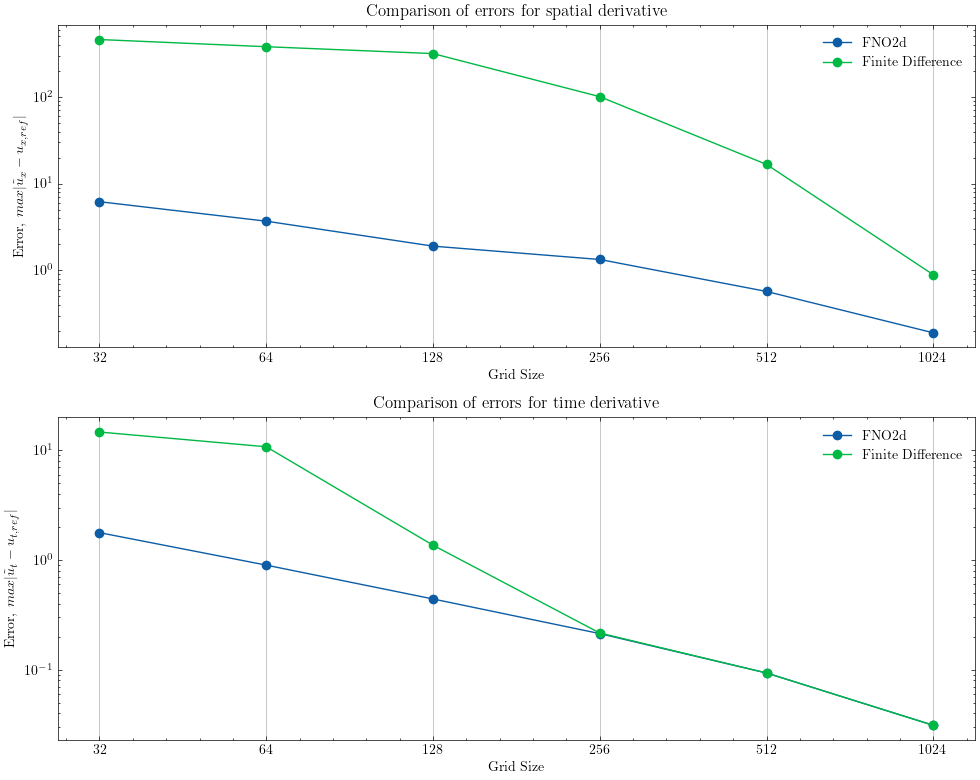

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
grid_size = jnp.array(grid_size)

# Plot errors for dx
axs[0].plot(jnp.log2(grid_size), errors_fno2d_dx, 'o-', label='FNO2d')
axs[0].plot(jnp.log2(grid_size), errors_finite_diff_dx, 'o-', label='Finite Difference')
axs[0].set_xticks(jnp.log2(grid_size))
axs[0].set_xticklabels(grid_size)
axs[0].set_xlabel('Grid Size')
axs[0].set_ylabel('Error, ' + r"$max|\tilde{u}_x - u_{x,ref}|$")
axs[0].set_title('Comparison of errors for spatial derivative')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].grid(axis='x')

# Plot errors for dt
axs[1].plot(jnp.log2(grid_size), errors_fno2d_dt, 'o-', label='FNO2d')
axs[1].plot(jnp.log2(grid_size), errors_finite_diff_dt, 'o-', label='Finite Difference')
axs[1].set_xticks(jnp.log2(grid_size))
axs[1].set_xticklabels(grid_size)
axs[1].set_xlabel('Grid Size')
axs[1].set_ylabel('Error, ' + r"$max|\tilde{u}_t - u_{t,ref}|$")
axs[1].set_title('Comparison of errors for time derivative')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].grid(axis='x')

plt.tight_layout()
plt.savefig('fno2d_dx_dt_errors.svg')
plt.show()

In [354]:
fno2d_derivatives_t = fno2d_instance.Dt(a, x, t)[3:-3,:]

In [355]:
fno2d_derivatives_x = fno2d_instance.Dx(a, x, t)

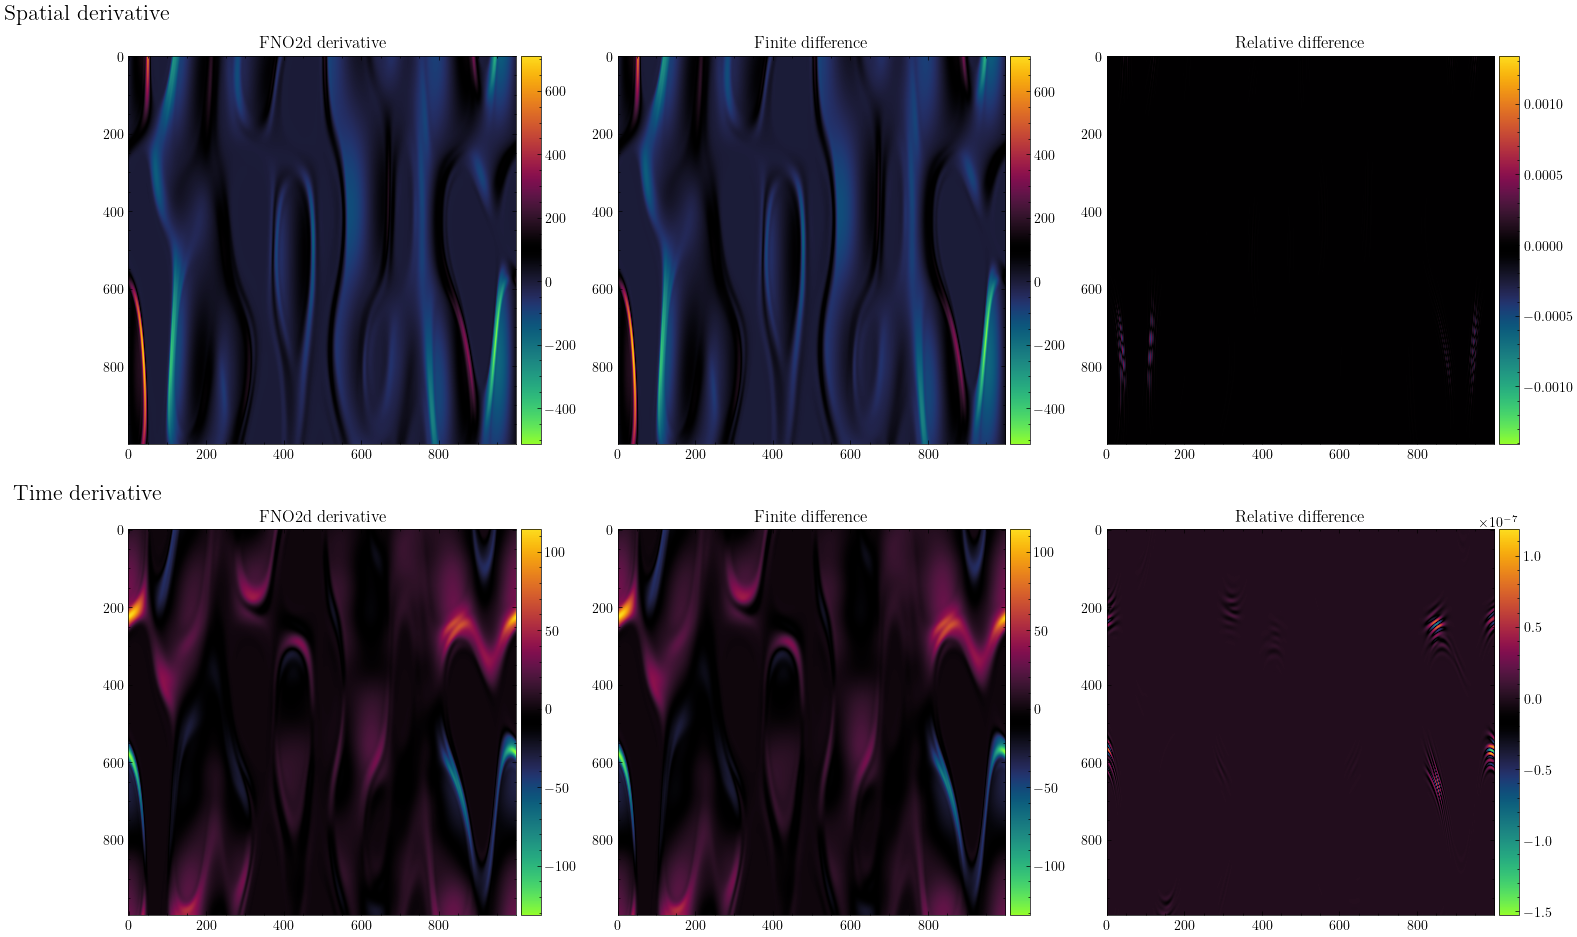

In [352]:
finite_diff_dx = Dx(u, x[1] - x[0], axis=1)
finite_diff_dt = Dx(u, t[1] - t[0], axis=0)[3:-3]

plt.figure(figsize=(15, 10))

# Add titles for rows
plt.figtext(0., 0.95, 'Spatial derivative', ha='center', va='center', fontsize=16)
plt.figtext(0., 0.47, 'Time derivative', ha='center', va='center', fontsize=16)

# Plot FNO2d Dx
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(fno2d_derivatives_x, cmap=cmap)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
ax1.set_title('FNO2d derivative')

# Plot Traditional Dx
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(finite_diff_dx, cmap=cmap)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)
ax2.set_title('Finite difference')

# Plot Difference
ax3 = plt.subplot(2, 3, 3)
im3 = ax3.imshow((fno2d_derivatives_x - finite_diff_dx)/jnp.max(jnp.abs(finite_diff_dx)), cmap=cmap)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)
ax3.set_title('Relative difference')

# Plot FNO2d Dt
ax4 = plt.subplot(2, 3, 4)
im4 = ax4.imshow(fno2d_derivatives_t, cmap=cmap)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im4, cax=cax4)
ax4.set_title('FNO2d derivative')

# Plot Traditional Dt
ax5 = plt.subplot(2, 3, 5)
im5 = ax5.imshow(finite_diff_dt, cmap=cmap)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im5, cax=cax5)
ax5.set_title('Finite difference')

# Plot Difference Dt
ax6 = plt.subplot(2, 3, 6)
im6 = ax6.imshow((fno2d_derivatives_t - finite_diff_dt)/jnp.max(jnp.abs(finite_diff_dt)), cmap=cmap)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im6, cax=cax6)
ax6.set_title('Relative difference')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('fno2d_derivatives_test.svg')
plt.show()